<a href="https://colab.research.google.com/github/Abdullahfoysal/SelfDrivingCar/blob/master/Trafic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [343]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [344]:
!ls german-traffic-signs/




signnames.csv  test.p  train.p	valid.p


In [345]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout
import random
import pickle
import pandas as pd
import cv2


In [346]:
np.random.seed(0)

In [347]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)

with open('german-traffic-signs/valid.p','rb') as f:
  val_data = pickle.load(f)

with open('german-traffic-signs/test.p','rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

<class 'dict'>


In [348]:
X_train, y_train = train_data['features'],train_data['labels']
X_val, y_val = val_data['features'],val_data['labels']
X_test, y_test = test_data['features'],test_data['labels']

In [349]:
print(X_train.shape)

(34799, 32, 32, 3)


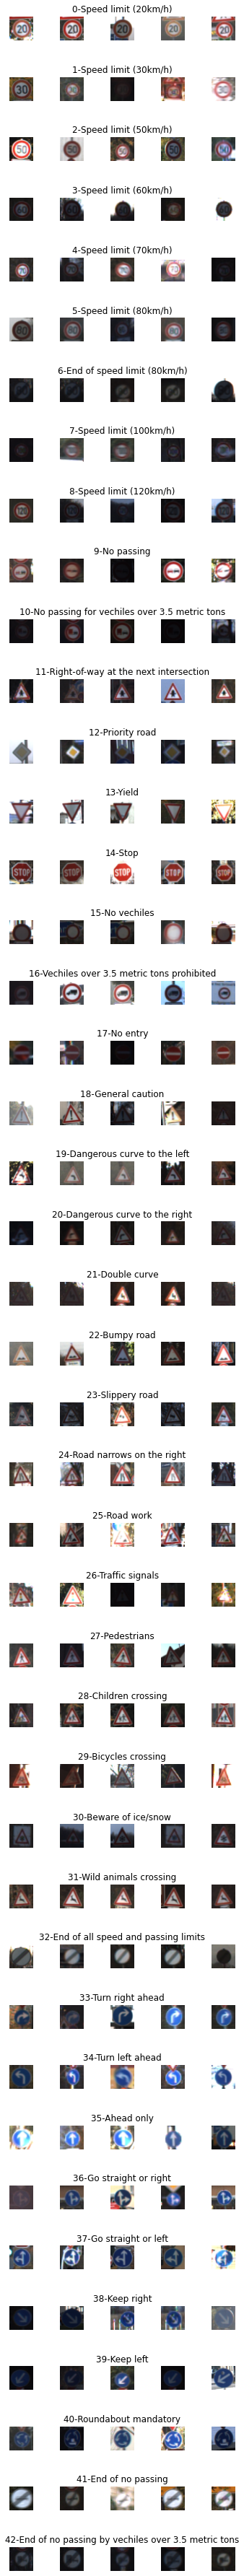

In [351]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+'-'+row['SignName'])
            num_of_samples.append(len(x_selected))
 

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


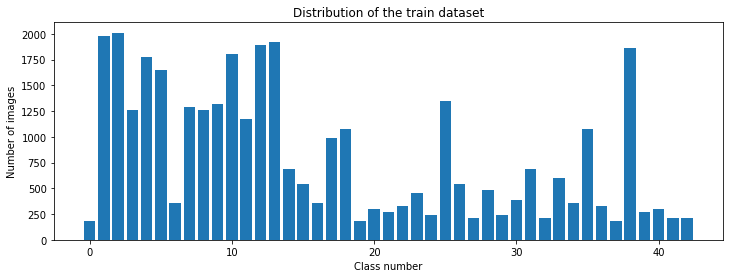

In [352]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


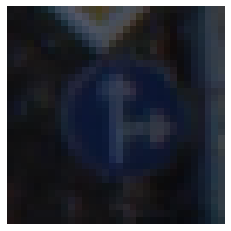

In [353]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


(32, 32)


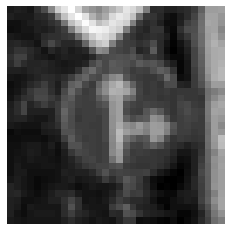

In [354]:
###PRE-PROCESSING-IMAGE###
def grayscale(img):
  img =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img,cmap =plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

(32, 32)


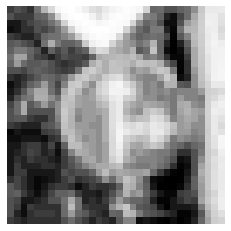

In [355]:
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img =equalize(img)
plt.imshow(img,cmap =plt.get_cmap("gray"))
plt.axis("off")
print(img.shape)

In [356]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing,X_train)))
X_val = np.array(list(map(preprocessing,X_val)))
X_test = np.array(list(map(preprocessing,X_test)))


(12630, 32, 32)


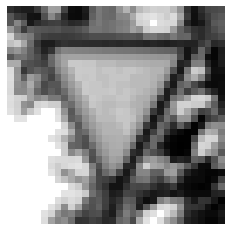

In [357]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)],cmap =plt.get_cmap("gray"))
plt.axis("off")
print(X_test.shape)

In [358]:
X_train = X_train.reshape(34799, 32, 32,1)
X_val = X_val.reshape(4410, 32, 32,1)
X_test = X_test.reshape(12630, 32, 32,1)



In [359]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                   height_shift_range=0.1,
                   zoom_range=0.2,
                   shear_range =0.1 ,
                   rotation_range=10)

datagen.fit(X_train)

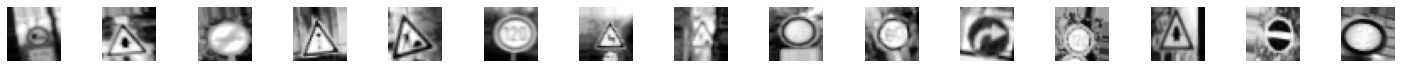

In [360]:
batches = datagen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)

fig,axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32),cmap =plt.get_cmap("gray"))
  axs[i].axis('off')

In [361]:
y_train = to_categorical(y_train,num_classes)
y_val = to_categorical(y_val,num_classes)
y_test = to_categorical(y_test,num_classes)

In [416]:
def modified_model():
  model =Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30,(3,3),activation='relu'))  
  model.add(Conv2D(30,(3,3),activation='relu'))  
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5)) 

  model.add(Flatten()) 
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  #compile model
  model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model



In [417]:
model = modified_model()
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_47 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_49 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                

In [418]:
history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch = 500,epochs=10,validation_data=(X_val,y_val),shuffle =True)

Epoch 1/10


<ipython-input-418-994f9722fedf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,y_train,batch_size=50),steps_per_epoch = 500,epochs=10,validation_data=(X_val,y_val),shuffle =True)


500/500 [==============================] - 12s 23ms/step - loss: 2.1678 - accuracy: 0.3908 - val_loss: 0.5077 - val_accuracy: 0.8431
Epoch 2/10
500/500 [==============================] - 11s 22ms/step - loss: 0.7573 - accuracy: 0.7631 - val_loss: 0.2174 - val_accuracy: 0.9356
Epoch 3/10
500/500 [==============================] - 12s 23ms/step - loss: 0.4467 - accuracy: 0.8594 - val_loss: 0.1254 - val_accuracy: 0.9578
Epoch 4/10
500/500 [==============================] - 11s 22ms/step - loss: 0.3365 - accuracy: 0.8948 - val_loss: 0.0930 - val_accuracy: 0.9732
Epoch 5/10
500/500 [==============================] - 11s 22ms/step - loss: 0.2757 - accuracy: 0.9141 - val_loss: 0.0571 - val_accuracy: 0.9821
Epoch 6/10
500/500 [==============================] - 11s 22ms/step - loss: 0.2190 - accuracy: 0.9311 - val_loss: 0.0647 - val_accuracy: 0.9825
Epoch 7/10
500/500 [==============================] - 11s 22ms/step - loss: 0.2075 - accuracy: 0.9354 - val_loss: 0.0703 - val_accuracy: 0.9778
Epo

Text(0.5, 0, 'epoch')

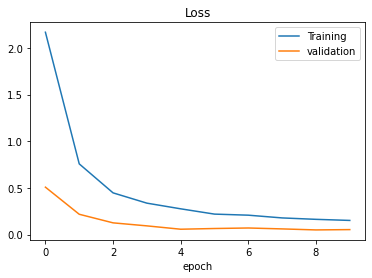

In [419]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','validation'])
plt.title("Loss")
plt.xlabel("epoch")

Text(0.5, 0, 'epoch')

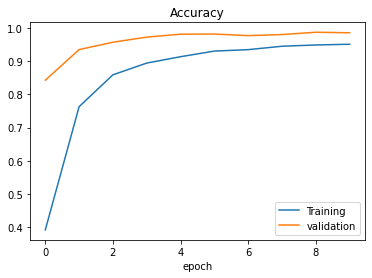

In [420]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training','validation'])
plt.title("Accuracy")
plt.xlabel("epoch")

In [421]:
score = model.evaluate(X_test,y_test,verbose =0)
print('Test Score:',score[0])
print("Test Accuracy: ",score[1])

Test Score: 0.12205170094966888
Test Accuracy:  0.9670625329017639


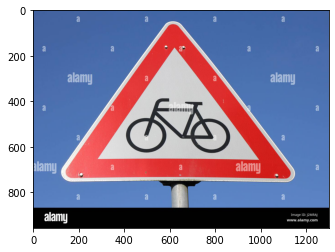

In [450]:
#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img)

(32, 32)


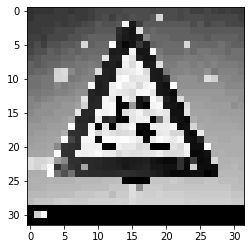

In [451]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img,cmap =plt.get_cmap("gray"))
print(img.shape)
 

In [452]:

#Reshape reshape
 
img = img.reshape(1, 32, 32, 1)

In [453]:
#Test image
predict_x=model.predict(img) 
prediction=np.argmax(predict_x,axis=1)
print("prediction sign: ",str(prediction))

1/1 [==============================] - 0s 19ms/step
prediction sign:  [29]


(900, 920, 3)


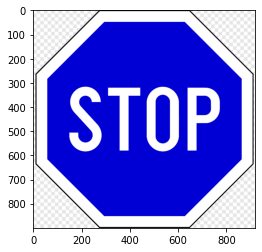

In [454]:
src ="./sample_image.png"
img_grayscale = cv2.imread(src,1)
plt.imshow(img_grayscale)
print(img_grayscale.shape)

(32, 32, 3)


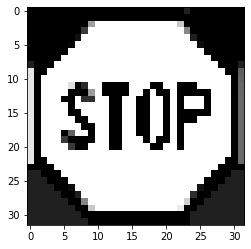

In [455]:
img_array = np.asarray(img_grayscale)
resize = cv2.resize(img_array,(32,32))
print(resize.shape)
gray_scale = cv2.cvtColor(resize,cv2.COLOR_BGR2GRAY)
image = cv2.bitwise_not(gray_scale)
plt.imshow(image,cmap =plt.get_cmap("gray"))

In [458]:
image = image/255
image = image.reshape(1,32,32,1)

predict_x=model.predict(image) 
prediction=np.argmax(predict_x,axis=1)
print("prediction sign: ",str(prediction))

1/1 [==============================] - 0s 19ms/step
prediction sign:  [40]
